In [1]:
'''
 # @ Author: Mitas Ray
 # @ Create Time: 2022-01-13 17:44:00
 # @ Description: This file implements functions from the pricing module
 # to show how to get the price and yield of a trade.
 '''

import numpy as np
import os
from google.cloud import bigquery

from ficc.utils.auxiliary_functions import sqltodf
from ficc.pricing.auxiliary_functions import transform_reference_data
from ficc.pricing.price import compute_price
from ficc.pricing.yield_rate import compute_yield

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../ficc/creds.json"    # put the location of your `creds.json` file

### Conditions that we tested on:
* `yield > 0`: conceptually, this notebook should work for any yield, but in practice, bonds with zero yield indicates a problem with MSRB data, and negative yields haven't been tested on
* `is_non_transaction_based_compensation is false`, `is_lop_or_takedown is false`: conceptually, this notebook should work without these filters, but in practice, away from market prices sometimes have anomolous yields reported in the MSRB data
* `callable_at_cav is false`: this notebook will not be correct for bonds callable at cav; future work will incorporate the special case of cav bonds that have call prices from ICE data
* `ice_valid_TO_date > timestamp(publish_datetime, "America/New_York")`, `timestamp(publish_datetime, "America/New_York") >= ice_valid_from_date`, `msrb_valid_to_date > publish_datetime`, `msrb_valid_from_date <= publish_datetime`: conditions to correctly join ICE and MSRB
* `par_call_price = 100`: conceptually this is identical to the fourth bullet point, but sometimes there are issues in the ICE data
* `interest_payment_frequency is not NULL`: if interest payment frequency is NULL, then the coupon frequency is unknown; possibly the field `coupon_type` could be used to determine the interest payment frequency

In [3]:
query = lambda trade_date: ''' SELECT
                                IFNULL(settlement_date, assumed_settlement_date) AS settlement_date,
                                trade_date,
                                cusip,
                                accrual_date,
                                dollar_price,
                                issue_price,
                                coupon,
                                interest_payment_frequency,
                                next_call_date,
                                par_call_date,
                                next_call_price,
                                par_call_price,
                                maturity_date,
                                previous_coupon_payment_date,
                                next_coupon_payment_date,
                                first_coupon_date,
                                coupon_type,
                                muni_security_type,
                                called_redemption_type,
                                refund_date,
                                refund_price,
                                is_callable,
                                is_called,
                                call_timing,
                                yield,
                                called_redemption_date,
                                rtrs_control_number,
                                has_zero_coupons,
                                last_period_accrues_from_date
                            FROM 
                                `eng-reactor-287421.auxiliary_views.trades_with_ref_data_pd`
                            WHERE 
                                yield > 0 and
                                is_non_transaction_based_compensation is false and 
                                callable_at_cav is false and 
                                is_lop_or_takedown is false and 
                                ice_valid_TO_date > timestamp(publish_datetime, "America/New_York") and
                                timestamp(publish_datetime, "America/New_York") >= ice_valid_from_date and
                                msrb_valid_to_date > publish_datetime and
                                msrb_valid_from_date <= publish_datetime and
                                par_call_price = 100 and
                                interest_payment_frequency is not NULL and 
                                trade_date = \'''' + trade_date + '''\'
                            '''

In [4]:
date = '2021-12-01'

In [5]:
bqclient = bigquery.Client()
muni_df = sqltodf(query(date), bqclient)
transform_reference_data(muni_df)

In [6]:
muni_df    # visualize the dataframe

,settlement_date,trade_date,cusip,accrual_date,dollar_price,issue_price,coupon,interest_payment_frequency,next_call_date,par_call_date,...,refund_price,is_callable,is_called,call_timing,yield,called_redemption_date,rtrs_control_number,has_zero_coupons,last_period_accrues_from_date,deferred
0,2021-12-03,2021-12-01,72771LBX6,2015-08-20,101.057,105.036471,4.00,2,2022-04-01,2022-04-01,...,100.0,False,True,1.0,0.762,2022-04-01,2021120104576600,False,2021-10-01,False
1,2021-12-03,2021-12-01,7417015S1,2019-05-22,110.818,102.198392,3.00,2,2029-07-15,2029-07-15,...,NaN,True,False,1.0,1.492,None,2021120105393900,False,2034-01-15,False
2,2021-12-03,2021-12-01,7417015S1,2019-05-22,110.818,102.198392,3.00,2,2029-07-15,2029-07-15,...,NaN,True,False,1.0,1.492,None,2021120105395800,False,2034-01-15,False
3,2021-12-03,2021-12-01,195864VN0,2021-03-30,109.841,105.902000,3.00,2,2029-02-15,2029-02-15,...,NaN,True,False,1.0,1.550,None,2021120102443700,False,2038-08-15,False
4,2021-12-03,2021-12-01,195864VN0,2021-03-30,109.056,105.902000,3.00,2,2029-02-15,2029-02-15,...,NaN,True,False,1.0,1.660,None,2021120102023500,False,2038-08-15,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12855,2021-12-03,2021-12-01,97712D7D2,2020-10-29,105.327,99.387737,3.00,2,2030-08-15,2030-08-15,...,NaN,True,False,1.0,2.320,None,2021120106437800,False,2052-02-15,False
12856,2021-12-02,2021-12-01,64966KP31,2013-08-15,107.982,113.618044,5.25,2,2023-08-01,2023-08-01,...,NaN,True,False,1.0,0.430,None,2021120100169400,False,2025-02-01,False
12857,2021-12-03,2021-12-01,591852M96,2019-06-19,113.776,115.051000,4.00,2,2026-03-01,2026-03-01,...,NaN,True,False,1.0,0.700,None,2021120101001100,False,2026-09-01,False
12858,2021-12-03,2021-12-01,050589QR4,2020-03-18,99.700,100.000000,2.32,2,2030-06-01,2030-06-01,...,NaN,True,False,1.0,2.348,None,2021120103213700,False,2033-12-01,False


Apply the `compute_price` function to every trade

In [7]:
muni_df['price_calc_from_yield'] = muni_df.apply(lambda x: compute_price(x), axis=1)

Plot the price from the reference data on the x-axis and our computed price on the y-axis

<AxesSubplot:xlabel='dollar_price', ylabel='price_from_yield'>

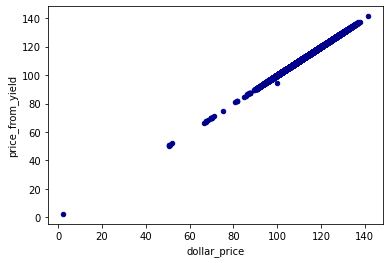

In [8]:
muni_df["price_from_yield"] = [x[0] for x in muni_df['price_calc_from_yield']]
muni_df.plot.scatter(x='dollar_price', y='price_from_yield', c='DarkBlue')

Return the sum and mean of the errors where the error is defined as the absolute distance between our computed price and the reference price

In [9]:
muni_df['price_delta'] = abs(muni_df['price_from_yield'] - muni_df['dollar_price'])
print("Sum of errors: {}".format(np.sum(muni_df['price_delta'])))
print("Mean of errors: {}".format(np.mean(muni_df['price_delta'])))

Sum of errors: 25.70499999999909
Mean of errors: 0.0019988335925349215


Apply the `compute_yield` function to every trade

In [10]:
muni_df["yield_and_calc_date"] = muni_df.apply(lambda x: compute_yield(x),axis=1)

Plot the yield from the reference data on the x-axis and our computed yield on the y-axis

<AxesSubplot:xlabel='yield', ylabel='yield_from_price'>

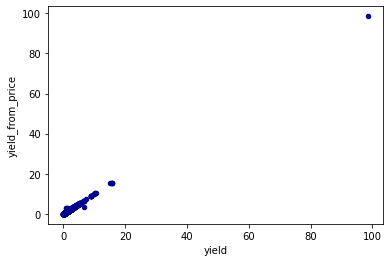

In [11]:
muni_df["yield_from_price"] = [x[0] for x in muni_df['yield_and_calc_date']]
muni_df["yield_calc_date"] = [x[1] for x in muni_df['yield_and_calc_date']]
# when we get close to redemption, it's difficult to compute the yield from the price
muni_df.plot.scatter(x='yield', y='yield_from_price', c='DarkBlue')

Return the sum and mean of the errors where the error is defined as the absolute distance between our computed yield and the reference yield

In [12]:
muni_df['ytw_delta'] = abs(muni_df['yield_from_price'] - muni_df['yield'])
print("Sum of errors: {}".format(np.sum(muni_df['ytw_delta'])))
print("Mean of errors: {}".format(np.mean(muni_df['ytw_delta'])))

Sum of errors: 16.732
Mean of errors: 0.0013010886469673405
